In [1]:
!pip install pyarrow
!pip install fastparquet

In [2]:
import numpy as np, pandas as pd, datetime as dt
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
from collections import defaultdict

def iter_to_str(iterable):
    return " ".join(map(lambda x: str(0) + str(x), iterable))

def apk(actual, predicted, k=12):
    if len(predicted) > k:
        predicted = predicted[:k]
    score, nhits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            nhits += 1.0
            score += nhits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12, return_apks=False):
    assert len(actual) == len(predicted)
    apks = [apk(ac, pr, k) for ac, pr in zip(actual, predicted) if 0 < len(ac)]
    if return_apks:
        return apks
    return np.mean(apks)

def blend(dt, w=[], k=12):
    if len(w) == 0:
        w = [1] * (len(dt))
    preds = []
    for i in range(len(w)):
        preds.append(dt[i].split())
    res = {}
    for i in range(len(preds)):
        if w[i] < 0:
            continue
        for n, v in enumerate(preds[i]):
            if v in res:
                res[v] += (w[i] / (n + 1))
            else:
                res[v] = (w[i] / (n + 1))    
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    return ' '.join(res[:k])

def prune(pred, ok_set, k=12):
    pred = pred.split()
    post = []
    for item in pred:
        if int(item) in ok_set and not item in post:
            post.append(item)
    return " ".join(post[:k])

def validation(actual, predicted, grouping, score=0, index=-1, ignore=False, figsize=(12, 6)):
    # actual, predicted : list of lists
    # group : pandas Series
    # score : pandas DataFrame
    if ignore: return
    ap12 = mapk(actual, predicted, return_apks=True)
    map12 = round(np.mean(ap12), 6)
    if isinstance(score, int): score = pd.DataFrame({g:[] for g in sorted(grouping.unique().tolist())})
    if index == -1 : index = score.shape[0]
    score.loc[index, "All"] = map12
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1); sns.histplot(data=ap12, log_scale=(0, 10), bins=20); plt.title(f"MAP@12 : {map12}")
    for g in grouping.unique():
        map12 = round(mapk(actual[grouping == g], predicted[grouping == g]), 6)
        score.loc[index, g] = map12
    plt.subplot(1, 2, 2); score[[g for g in grouping.unique()[::-1]] + ['All']].loc[index].plot.barh(); plt.title(f"MAP@12 of Groups")
    vc = pd.Series(predicted).apply(len).value_counts()
    score.loc[index, "Fill"] = round(1 - sum(vc[k] * (12 - k) / 12 for k in (set(range(12)) & set(vc.index))) / len(actual), 3) * 100
    display(score)
    return score

In [3]:
val_week = 104

In [4]:
df = pd.read_parquet('../input/hm-parquets-of-datasets/transactions_train.parquet')
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
cid = pd.DataFrame(sub.customer_id.apply(lambda s: int(s[-16:], 16)))

In [5]:
group = df.groupby('customer_id').sales_channel_id.mean().round().reset_index()\
    .merge(cid, on='customer_id', how='right').rename(columns={'sales_channel_id':'group'})
grouping = group.group.fillna(1.0)

In [6]:
# id of week to be used in a validation; set 105 if you would like to create a submission
val = df.loc[df.week == val_week].groupby('customer_id').article_id.apply(iter_to_str).reset_index()\
    .merge(cid, on='customer_id', how='right')
actual = val.article_id.apply(lambda s: [] if pd.isna(s) else s.split())
last_date = df.loc[df.week < val_week].t_dat.max()

## 定番を抜き出す

In [7]:
# 2018
day = 20
start = dt.datetime(2018,9,day,0,0)
end = dt.datetime(2018,9,day,23,59)
x = df.loc[(df.t_dat >= start) & (df.t_dat <= end)].article_id.tolist()

popular = set(x)
print(len(x))

for day in range(20, 31, 1) :
    start = dt.datetime(2018,9,day,0,0)
    end = dt.datetime(2018,9,day,23,59)
    x = df.loc[(df.t_dat >= start) & (df.t_dat <= end)].article_id.tolist()
    popular &= set(x)
    print(start, end, len(x), len(popular))

# 2019
for day in range(15, 30, 1) :
    start = dt.datetime(2019,9,day,0,0)
    end = dt.datetime(2019,9,day,23,59)
    x = df.loc[(df.t_dat >= start) & (df.t_dat <= end)].article_id.tolist()
    popular &= set(x)
    print(start, end, len(x), len(popular))

# 2020
for day in range(15, 23, 1) :
    start = dt.datetime(2020,9,day,0,0)
    end = dt.datetime(2020,9,day,23,59)
    x = df.loc[(df.t_dat >= start) & (df.t_dat <= end)].article_id.tolist()
    popular &= set(x)
    print(start, end, len(x), len(popular))


48399
2018-09-20 00:00:00 2018-09-20 23:59:00 48399 11542
2018-09-21 00:00:00 2018-09-21 23:59:00 47543 7812
2018-09-22 00:00:00 2018-09-22 23:59:00 17635 4457
2018-09-23 00:00:00 2018-09-23 23:59:00 52230 3910
2018-09-24 00:00:00 2018-09-24 23:59:00 45984 3556
2018-09-25 00:00:00 2018-09-25 23:59:00 43857 3272
2018-09-26 00:00:00 2018-09-26 23:59:00 48224 3121
2018-09-27 00:00:00 2018-09-27 23:59:00 44261 2970
2018-09-28 00:00:00 2018-09-28 23:59:00 66900 2898
2018-09-29 00:00:00 2018-09-29 23:59:00 141700 2857
2018-09-30 00:00:00 2018-09-30 23:59:00 38043 2590
2019-09-15 00:00:00 2019-09-15 23:59:00 31112 499
2019-09-16 00:00:00 2019-09-16 23:59:00 33716 356
2019-09-17 00:00:00 2019-09-17 23:59:00 37008 312
2019-09-18 00:00:00 2019-09-18 23:59:00 39063 290
2019-09-19 00:00:00 2019-09-19 23:59:00 36491 275
2019-09-20 00:00:00 2019-09-20 23:59:00 31508 257
2019-09-21 00:00:00 2019-09-21 23:59:00 20542 234
2019-09-22 00:00:00 2019-09-22 23:59:00 33950 220
2019-09-23 00:00:00 2019-09-23 

In [8]:
import json

if val_week == 104 :
    print("item2vec = 104")
    with open('../input/handmitem2vec/cust_buy104.json', "r") as f :
        cust_buy = json.load(f)
else :
    with open('../input/handmitem2vec/cust_buy.json', "r") as f :
        cust_buy = json.load(f)

item2vec = 104


In [39]:
from tqdm import tqdm

l = []
for i in tqdm(range(len(sub))):
    c_id = sub['customer_id'][i]
    if c_id not in cust_buy :
        l.append("")
        continue
        
    t = set()
    li = cust_buy[c_id].split(" ")
    #li.reverse()
#     print(cid, li)
    for e in li:
        if int(e) in popular :
            t.add(e)
#     if len(t) != 0 : print(cid, t)
    l.append(" ".join(t))
#     break
sub['popular'] = l 

100%|██████████| 1371980/1371980 [00:08<00:00, 156302.76it/s]


In [40]:
sub.head()

,customer_id,prediction,popular,popular_items
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006 0918522001 0924243001 0919273002 09...,0568601006,0918522001 0924243001 0919273002 0914805002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0658298001 0673677002 0865799006 0809238001 09...,0658298001 0673677002,0865799006 0809238001 0924243001 0909370001 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0865799006 0809238001 0924243001 0909370001 08...,,0865799006 0809238001 0924243001 0909370001 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0924243001 0923758001 0865799006 0751471001 09...,,0924243001 0923758001 0865799006 0751471001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0924243001 0923758001 0865799006 0751471001 09...,,0924243001 0923758001 0865799006 0751471001 09...


,1.0,2.0,All,Fill
anytime popular,0.003406,0.002471,0.00278,3.4


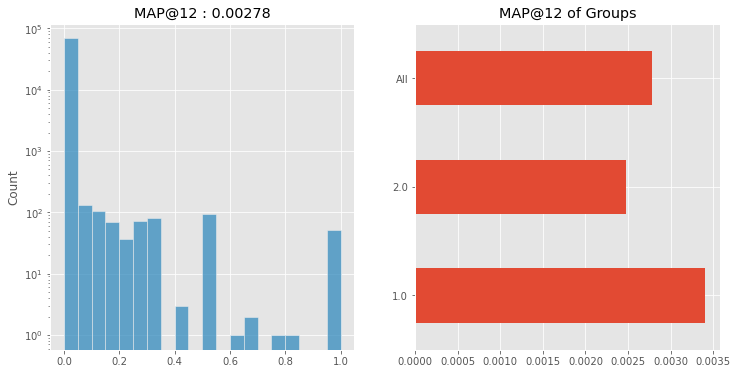

In [41]:
predicted = sub['popular'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, index='anytime popular', ignore=(val_week == 105))

## 最終週のトレンド

In [12]:
cdf = pd.read_parquet('../input/handmitem2vec/customers.parquet')
cdf = cdf[['customer_id','age','attribute']]
#listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
listBin = [-1, 19, 34, 49, 119]
#cdf['cust_feature'] = pd.cut(cdf['age'], listBin).astype(str).str.cat(cdf['attribute'].astype(str))
#cdf['cust_feature'] = pd.qcut(cdf['age'], 10).astype(str).str.cat(cdf['attribute'].astype(str))
#cdf['cust_feature'] = pd.cut(cdf['age'], listBin).astype(str)
cdf['cust_feature'] = pd.qcut(cdf['age'], 10).astype(str)
cdf = cdf.drop('age', axis=1)
cdf = cdf.drop('attribute', axis=1)
cdf['cust_feature'].unique()

array(['(46.0, 51.0]', '(23.0, 25.0]', '(51.0, 57.0]', '(-1.001, 20.0]',
       '(31.0, 38.0]', '(28.0, 31.0]', '(57.0, 99.0]', '(38.0, 46.0]',
       '(25.0, 28.0]', '(20.0, 23.0]'], dtype=object)

In [13]:
# 4日間の売れた商品リスト
init_date = last_date - dt.timedelta(days=4)
sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())
len(sold_set)

16423

In [14]:
init_date = last_date - dt.timedelta(days=5 - 1)
group_df = pd.concat([cid, group.group.fillna(1)], axis=1) # grouping can be changed
group_df = group_df.merge(cdf, on='customer_id', how='right')
group_df.columns = ['customer_id', 'group', 'cust_feature']
group_df['cust_feature'] = group_df['group'].astype(str).str.cat(group_df['cust_feature'])
train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .merge(group_df, on='customer_id', how='left')\
    .groupby(['cust_feature', 'article_id']).t_dat.count().reset_index()

items = defaultdict(str)
for g in train.cust_feature.unique():
#    items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:30])
    items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:20])

sub['popular_items'] = group_df.cust_feature.map(items)

,1.0,2.0,All,Fill
anytime popular,0.003406,0.002471,0.002780,3.4
Popular Items,0.010388,0.009330,0.009679,100.0


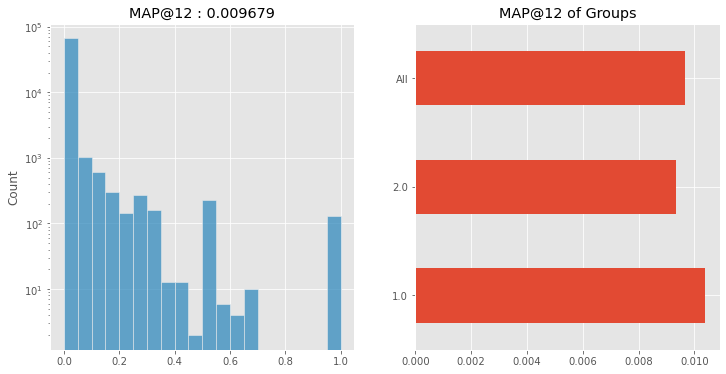

In [15]:
predicted = sub['popular_items'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Popular Items', ignore=(val_week == 105))
#0.012127 12, 0.012550 15, 0.013163 20 

## マージ

In [17]:
# 11日間の売れた商品リスト
init_date = last_date - dt.timedelta(days=11)
sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())

,1.0,2.0,All,Fill
anytime popular,0.003406,0.002471,0.002780,3.4
Popular Items,0.010388,0.009330,0.009679,100.0
Prediction,0.011710,0.010272,0.010747,100.0


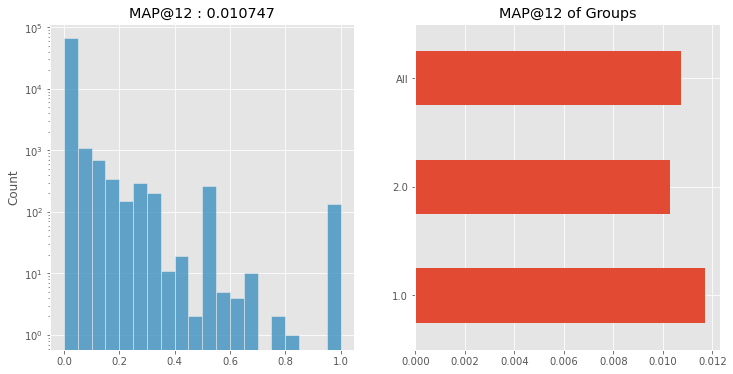

In [18]:
# 11日間に販売実績のある商品だけ対象
sub['prediction'] = sub[['popular', 'popular_items']]\
    .apply(blend, w=[100, 1], axis=1, k=32).apply(prune, ok_set=sold_set)
# sub['prediction'] = sub[['last_purchase', 'other_colors', 'popular_items', 'kangol']]\
#     .apply(blend, w=[0, 0, 0, 1], axis=1, k=32).apply(prune, ok_set=sold_set)

predicted = sub.prediction.apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Prediction', ignore=(val_week == 105))